In [24]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr, spearmanr, zscore

In [25]:
# jaywalking criminal summonses by quarter

jaywalking_crim_summonses_quarterly = pd.read_csv('../data/output/jaywalking_crim_summonses_quarterly.csv')

In [26]:
# uploading crash data (has data on persons involved in collisions)

collisions_person_dataset = pd.read_csv('https://data.cityofnewyork.us/resource/f55k-p6yu.csv?$limit=9999999')

In [79]:
collisions_person_dataset['crash_date'] = pd.to_datetime(collisions_person_dataset['crash_date'])

# creating quarter column 
collisions_person_dataset['quarter'] = collisions_person_dataset['crash_date'].dt.quarter.astype(str) 
collisions_person_dataset['quarter'] = 'Q' + collisions_person_dataset['quarter']
collisions_person_dataset['year'] = collisions_person_dataset['crash_date'].dt.year.astype(str)
collisions_person_dataset['quarter'] = collisions_person_dataset['year'] + ' ' + collisions_person_dataset['quarter']

In [80]:
# will be used to normalize

collisions_per_quarter = collisions_person_dataset.groupby('quarter').count()[['unique_id']].rename(columns={'unique_id':'total_collisions'})
collisions_per_quarter = collisions_per_quarter.loc[:'2024 Q2'] # Q3 not over yet

In [81]:
# creating pedestrian collisions dataset

pedestrian_collisions = collisions_person_dataset[collisions_person_dataset['person_type'] == 'Pedestrian']
pedestrian_collisions['pedestrians_killed'] = np.where(pedestrian_collisions['person_injury'] == 'Killed', 1, 0)
pedestrian_collisions['pedestrians_injured'] = np.where(pedestrian_collisions['person_injury'] == 'Injured', 1, 0)
pedestrian_collisions['pedestrian_ksi'] = np.where(pedestrian_collisions['person_injury'].isin(['Injured', 'Killed']), 1, 0)

/var/folders/0x/wbh6lcrn3t7046vw2zxtbrhxrc0v0g/T/ipykernel_53621/1898355313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrian_collisions['pedestrians_killed'] = np.where(pedestrian_collisions['person_injury'] == 'Killed', 1, 0)
/var/folders/0x/wbh6lcrn3t7046vw2zxtbrhxrc0v0g/T/ipykernel_53621/1898355313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedestrian_collisions['pedestrians_injured'] = np.where(pedestrian_collisions['person_injury'] == 'Injured', 1, 0)
/var/folders/0x/wbh6lcrn3t70

In [82]:
# will be used to normalize

ped_collisions_per_quarter = pedestrian_collisions.groupby('quarter').count()[['unique_id']].rename(columns={'unique_id':'pedestrian_collisions'})

In [83]:
# important to note that 32% of pedestrian collisions have 'ped_action' listed as null
# this means that subsetting the dataset based on 'ped_action' entries that indicate jaywalking will likely result in false negatives
# will run regression on both all pedestrian collisions AND all jaywalking collisions in case the results differ

round((100*pedestrian_collisions['ped_action'].value_counts(dropna=False) / len(pedestrian_collisions['ped_action'])),2)

ped_action
NaN                                                32.53
Crossing With Signal                               25.69
Crossing, No Signal, or Crosswalk                  11.66
Crossing, No Signal, Marked Crosswalk               5.86
Other Actions in Roadway                            5.11
Crossing Against Signal                             4.69
Unknown                                             3.21
Not in Roadway                                      3.19
Does Not Apply                                      2.74
Emerging from in Front of/Behind Parked Vehicle     2.16
Working in Roadway                                  1.01
Getting On/Off Vehicle Other Than School Bus        0.92
Riding/Walking Along Highway With Traffic           0.46
Playing in Roadway                                  0.37
Riding/Walking Along Highway Against Traffic        0.17
Pushing/Working on Car                              0.16
Going to/From Stopped School Bus                    0.06
Name: count, dtype: 

In [84]:
# with that in mind...
# narrowing down to just crashes involving jaywalkers (based on available data)
    # 1) crossing without a signal AND not in a crosswalk
    # 2) crossing in a crosswalk without a signal
    # 3) crossing without a signal

jaywalking_collisions = pedestrian_collisions[pedestrian_collisions['ped_action'].isin(['Crossing, No Signal, or Crosswalk', 'Crossing, No Signal, Marked Crosswalk', 'Crossing Against Signal'])]

In [85]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing, No Signal, or Crosswalk'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection    11155
Pedestrian/Bicyclist/Other Pedestrian at Intersection         3513
Does Not Apply                                                 242
Unknown                                                        204
NaN                                                              9
Name: count, dtype: int64

In [86]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing, No Signal, Marked Crosswalk'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian at Intersection        6664
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection     796
Does Not Apply                                                 73
Unknown                                                        58
NaN                                                             6
Name: count, dtype: int64

In [87]:
# investigating where these types of crashes occur

jaywalking_collisions[jaywalking_collisions['ped_action'] == 'Crossing Against Signal'][['ped_location']].value_counts(dropna=False)

ped_location                                             
Pedestrian/Bicyclist/Other Pedestrian at Intersection        4858
Pedestrian/Bicyclist/Other Pedestrian Not at Intersection    1108
Unknown                                                        71
Does Not Apply                                                 49
NaN                                                             3
Name: count, dtype: int64

In [88]:
# grouping by quater
# pre-2016 Q2 seems badly affected by NaN issue
# should just look at 2016 and beyond for jaywalking dataset

jaywalking_collisions_per_quarter = jaywalking_collisions.groupby('quarter').agg({'unique_id': 'count', 'pedestrians_injured': 'sum', 'pedestrians_killed': 'sum', 'pedestrian_ksi': 'sum'}).rename(columns={'unique_id':'jaywalking_collisions'})
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(ped_collisions_per_quarter, on='quarter', how='left')
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(collisions_per_quarter, on='quarter', how='left')
jaywalking_collisions_per_quarter['jay_share_collisions'] = round((100*jaywalking_collisions_per_quarter['jaywalking_collisions'] / jaywalking_collisions_per_quarter['total_collisions']),2)
jaywalking_collisions_per_quarter['ped_share_collisions'] = round((100*jaywalking_collisions_per_quarter['pedestrian_collisions'] / jaywalking_collisions_per_quarter['total_collisions']),2)
jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.merge(jaywalking_crim_summonses_quarterly, on='quarter', how='left')


In [89]:
# eliminating pre-2016 quarters (plus not including 2024 Q3 because it's not over)

jaywalking_collisions_per_quarter = jaywalking_collisions_per_quarter.loc[5:38]

In [145]:
# creating df without outliers

# identify outliers using Z-score
jaywalking_collisions_per_quarter['zscore_jaywalking_collisions'] = zscore(jaywalking_collisions_per_quarter['jaywalking_collisions'])
jaywalking_collisions_per_quarter['zscore_pedestrian_collisions'] = zscore(jaywalking_collisions_per_quarter['pedestrian_collisions'])
jaywalking_collisions_per_quarter['zscore_total_collisions'] = zscore(jaywalking_collisions_per_quarter['total_collisions'])
jaywalking_collisions_per_quarter['zscore_pedestrian_ksi'] = zscore(jaywalking_collisions_per_quarter['pedestrian_ksi'])
jaywalking_collisions_per_quarter['zscore_jay_share_collisions'] = zscore(jaywalking_collisions_per_quarter['jay_share_collisions'])
jaywalking_collisions_per_quarter['zscore_ped_share_collisions'] = zscore(jaywalking_collisions_per_quarter['ped_share_collisions'])
jaywalking_collisions_per_quarter['zscore_total_summonses'] = zscore(jaywalking_collisions_per_quarter['total_summonses'])


In [146]:
# jaywalking collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_jaywalking_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

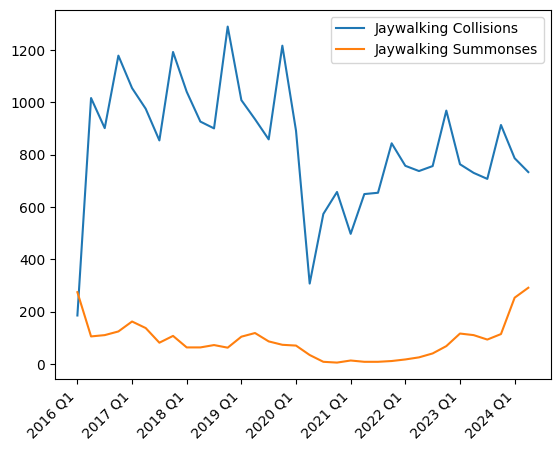

In [147]:
# since there are no outliers, proceed

# plot lines 

quarter = jaywalking_collisions_per_quarter['quarter']
jaywalking_collisions = jaywalking_collisions_per_quarter['jaywalking_collisions']
jaywalking_summonses = jaywalking_collisions_per_quarter['total_summonses']

plt.plot(quarter, jaywalking_collisions, label = "Jaywalking Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# Set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

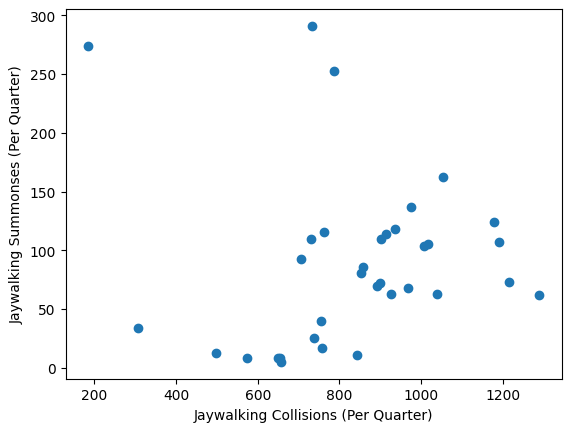

In [148]:
# scatter plot

# add axis labels
plt.xlabel('Jaywalking Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(jaywalking_collisions, jaywalking_summonses)
plt.show()

In [149]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses, jaywalking_collisions)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses, jaywalking_collisions)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.006785936997655037 (p-value: 0.9696168698742225)
Spearman correlation: 0.34867016811943347 (p-value: 0.04328476989789947)


In [150]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['jaywalking_collisions_lagged'] = lagged_df['jaywalking_collisions'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
jaywalking_collisions_lagged = lagged_df['jaywalking_collisions_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged, jaywalking_collisions_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, jaywalking_collisions_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.3127424472416475 (p-value: 0.07638637015617997)
Spearman correlation: 0.4253469854578946 (p-value: 0.013598990765704286)


In [151]:
# pedestrian collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_pedestrian_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

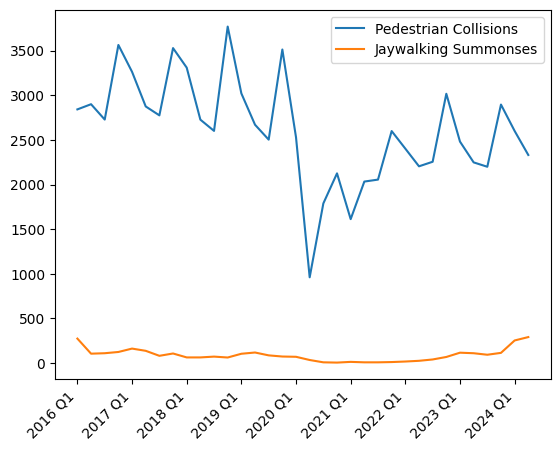

In [152]:
# since there are no outliers, proceed

# plot lines 

pedestrian_collisions = jaywalking_collisions_per_quarter['pedestrian_collisions']

plt.plot(quarter, pedestrian_collisions, label = "Pedestrian Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

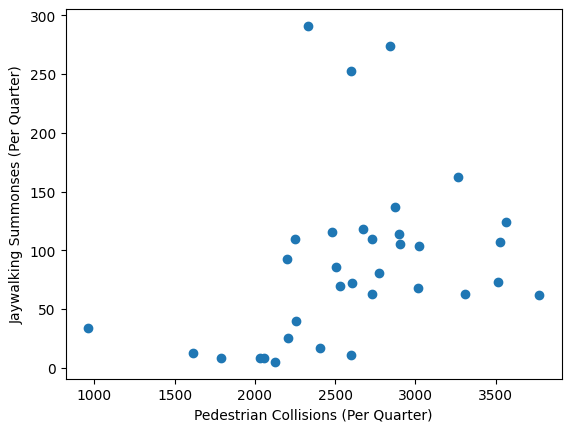

In [153]:
# scatter plot

# add axis labels
plt.xlabel('Pedestrian Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(pedestrian_collisions, jaywalking_summonses)
plt.show()

In [154]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses, pedestrian_collisions)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses, pedestrian_collisions)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.3233150539030738 (p-value: 0.06215813448664816)
Spearman correlation: 0.49357999686876397 (p-value: 0.003013032685515805)


In [155]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['pedestrian_collisions_lagged'] = lagged_df['pedestrian_collisions'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
pedestrian_collisions_lagged = lagged_df['pedestrian_collisions_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged, pedestrian_collisions_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, pedestrian_collisions_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.30393153063366435 (p-value: 0.08550917479617696)
Spearman correlation: 0.44658089550237284 (p-value: 0.009180886406901182)


In [156]:
# jaywalking share of total collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_jay_share_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

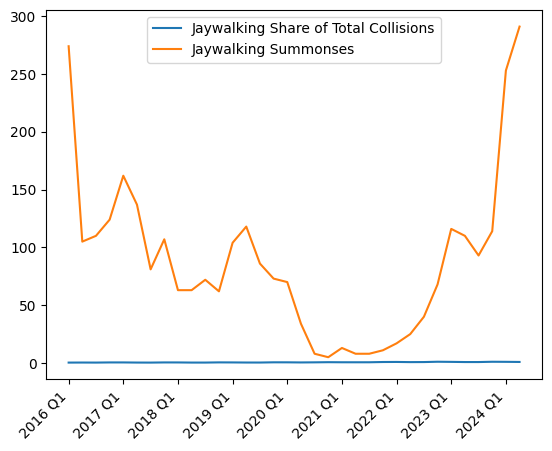

In [157]:
# since there are no outliers, proceed

# plot lines 

jay_share_collisions = jaywalking_collisions_per_quarter['jay_share_collisions']

plt.plot(quarter, jay_share_collisions, label = "Jaywalking Share of Total Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

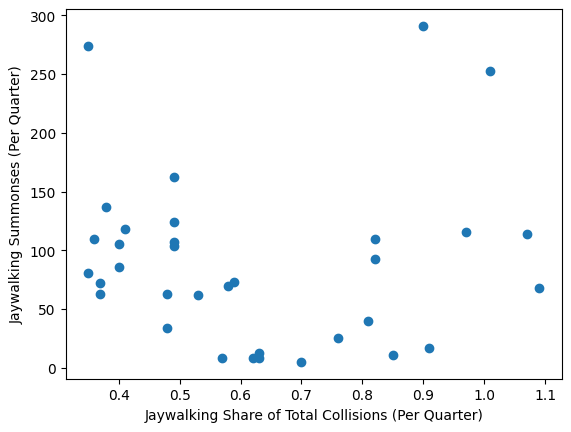

In [158]:
# scatter plot

# add axis labels
plt.xlabel('Jaywalking Share of Total Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(jay_share_collisions, jaywalking_summonses)
plt.show()

In [159]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jay_share_collisions, jaywalking_summonses)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jay_share_collisions, jaywalking_summonses)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.016115554912806498 (p-value: 0.9279217499005645)
Spearman correlation: -0.15801963610386968 (p-value: 0.37208926548696275)


In [160]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['jay_share_collisions_lagged'] = lagged_df['jay_share_collisions'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
jay_share_collisions_lagged = lagged_df['jay_share_collisions_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged, jay_share_collisions_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, jay_share_collisions_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: -0.22204002741312956 (p-value: 0.214268276353654)
Spearman correlation: -0.33564921217391136 (p-value: 0.056181329845952296)


In [161]:
# pedestrian share of total collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_ped_share_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

False

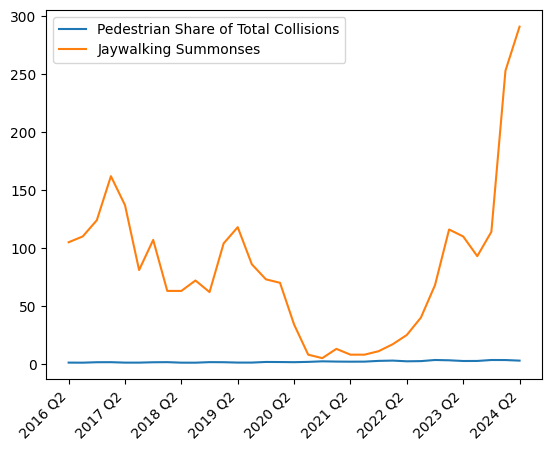

In [162]:
# use no outliers df

# plot lines 

quarter_no_outliers = df_no_outliers['quarter']
jaywalking_summonses_no_outliers = df_no_outliers['total_summonses']
ped_share_collisions_no_outliers = df_no_outliers['ped_share_collisions']

plt.plot(quarter_no_outliers, ped_share_collisions_no_outliers, label = "Pedestrian Share of Total Collisions") 
plt.plot(quarter_no_outliers, jaywalking_summonses_no_outliers, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

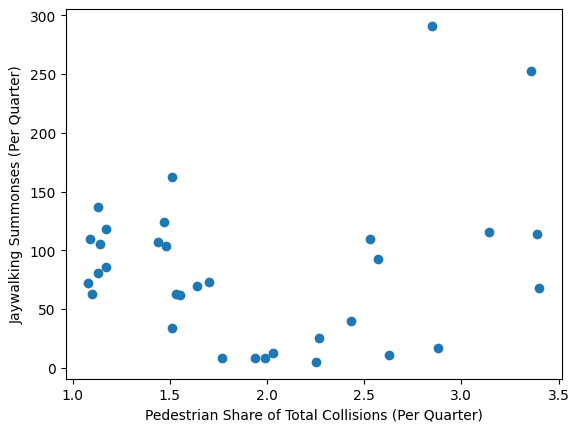

In [163]:
# pedestrian collisions vs jaywalking summonses

# scatter plot

# add axis labels
plt.xlabel('Pedestrian Share of Total Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(ped_share_collisions_no_outliers, jaywalking_summonses_no_outliers)
plt.show()

In [164]:
# including outlier

ped_share_collisions = jaywalking_collisions_per_quarter['ped_share_collisions']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(ped_share_collisions, jaywalking_summonses)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(ped_share_collisions, jaywalking_summonses)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.38180909974579624 (p-value: 0.025866264059794655)
Spearman correlation: -0.039446526532376375 (p-value: 0.824708238084743)


In [165]:
# exluding outlier

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(ped_share_collisions_no_outliers, jaywalking_summonses_no_outliers)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(ped_share_collisions_no_outliers, jaywalking_summonses_no_outliers)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.14412547007243692 (p-value: 0.4235921913659567)
Spearman correlation: -0.1349611213967667 (p-value: 0.45395680556924867)


In [166]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['ped_share_collisions_lagged'] = lagged_df['ped_share_collisions'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
ped_share_collisions_lagged = lagged_df['ped_share_collisions_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged, ped_share_collisions_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, ped_share_collisions_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: -0.2179564116792107 (p-value: 0.2230334779437531)
Spearman correlation: -0.3217660440735801 (p-value: 0.06784436601669355)


In [167]:
# pedestrian ksi vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_pedestrian_ksi']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

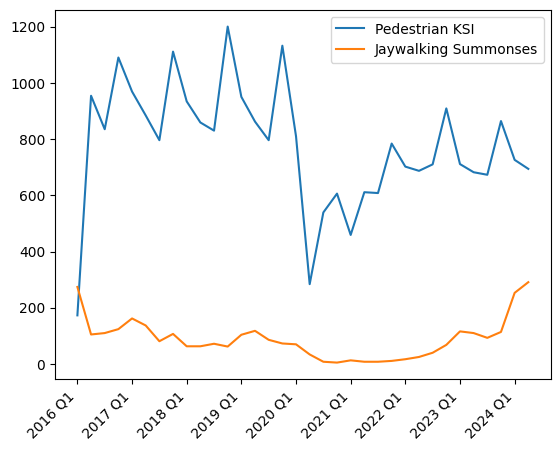

In [168]:
# since no outliers, proceed

# plot lines 

pedestrian_ksi = jaywalking_collisions_per_quarter['pedestrian_ksi']

plt.plot(quarter, pedestrian_ksi, label = "Pedestrian KSI") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

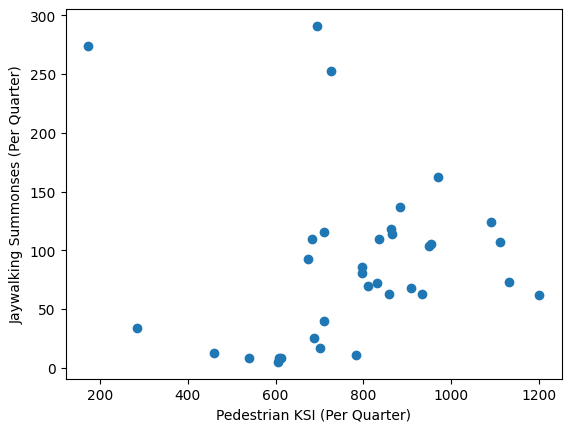

In [169]:
# pedestrian ksi vs jaywalking summonses

# scatter plot

# add axis labels
plt.xlabel('Pedestrian KSI (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(pedestrian_ksi, jaywalking_summonses)
plt.show()

In [170]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses, pedestrian_ksi)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses, pedestrian_ksi)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.008545979180486697 (p-value: 0.9617416764243261)
Spearman correlation: 0.36276086116300943 (p-value: 0.03498386329089885)


In [172]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['pedestrian_ksi_lagged'] = lagged_df['pedestrian_ksi'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
pedestrian_ksi_lagged = lagged_df['pedestrian_ksi_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged , pedestrian_ksi_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, pedestrian_ksi_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.31560823476857736 (p-value: 0.07358780493605417)
Spearman correlation: 0.43156930449102787 (p-value: 0.012150308270502003)


In [173]:
# total collisions vs jaywalking summonses

# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = jaywalking_collisions_per_quarter[(np.abs(jaywalking_collisions_per_quarter['zscore_total_summonses']) < 3) & (np.abs(jaywalking_collisions_per_quarter['zscore_total_collisions']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(jaywalking_collisions_per_quarter)

True

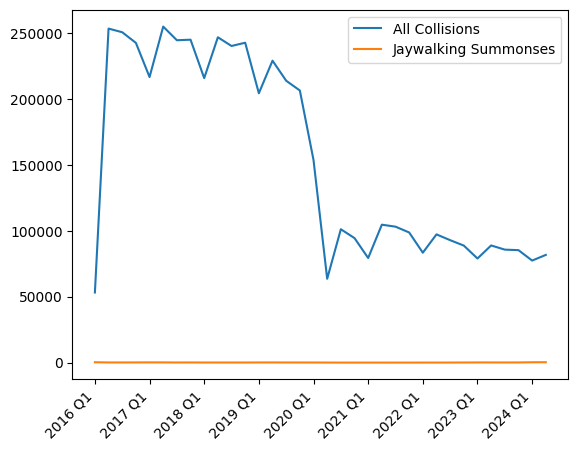

In [174]:
# since no outliers, proceed

# plot lines 

total_collisions = jaywalking_collisions_per_quarter['total_collisions']

plt.plot(quarter, total_collisions, label = "All Collisions") 
plt.plot(quarter, jaywalking_summonses, label = "Jaywalking Summonses") 

# set maximum number of x-ticks
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

# rotate x-tick labels for better readability
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.legend() 
plt.show()

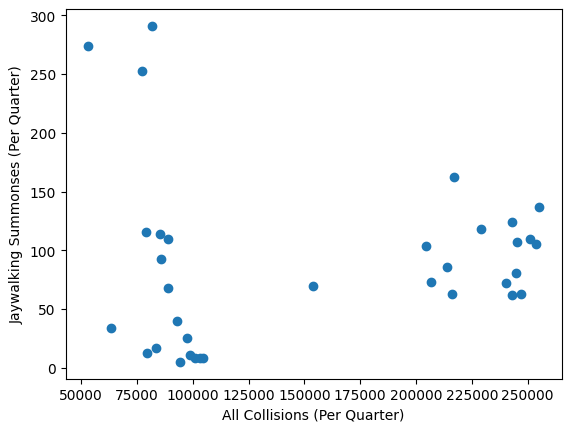

In [175]:
# total collisions vs jaywalking summonses

# scatter plot

# add axis labels
plt.xlabel('All Collisions (Per Quarter)')
plt.ylabel('Jaywalking Summonses (Per Quarter)')

plt.scatter(total_collisions, jaywalking_summonses)
plt.show()

In [176]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses, total_collisions)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses, total_collisions)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.0299275379746648 (p-value: 0.8665705387928824)
Spearman correlation: 0.07459493294269336 (p-value: 0.6750150733991245)


In [177]:
# adding a one-quarter lag

lagged_df = deepcopy(jaywalking_collisions_per_quarter)
lagged_df['total_collisions_lagged'] = lagged_df['total_collisions'].shift(-1)
lagged_df = lagged_df.dropna()

jaywalking_summonses_lagged = lagged_df['total_summonses']
total_collisions_lagged = lagged_df['total_collisions_lagged']

# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(jaywalking_summonses_lagged, total_collisions_lagged)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(jaywalking_summonses_lagged, total_collisions_lagged)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.4053454070398345 (p-value: 0.019273094607371994)
Spearman correlation: 0.34893834852618943 (p-value: 0.0465621048677964)


### Geography

In [ ]:
# now looking across precincts

summonses_v_ksi = pd.read_csv('../data/output/summonses-vs-ksi_by-precinct_2017-2024.csv').drop(columns=['Unnamed: 0'])
precinct_data = pd.read_csv('../data/input/precinct-geographies_2021.csv')

# adding total population column
summonses_v_ksi = summonses_v_ksi.merge(precinct_data[['policeprct','Total population']], left_on='precinct', right_on='policeprct').drop(columns=['policeprct'])


In [ ]:
# normalizing by population

summonses_v_ksi['pedestrian_ksi_per10K'] = 10000*summonses_v_ksi['pedestrian_ksi'] / summonses_v_ksi['Total population']
summonses_v_ksi['total_jaywalking_summonses_per10K'] = 10000*summonses_v_ksi['total_jaywalking_summonses'] / summonses_v_ksi['Total population']


In [ ]:
# identify outliers using Z-score
summonses_v_ksi['zscore_pedestrian_ksi_per10K'] = zscore(summonses_v_ksi['pedestrian_ksi_per10K'])
summonses_v_ksi['zscore_total_jaywalking_summonses_per10K'] = zscore(summonses_v_ksi['total_jaywalking_summonses_per10K'])

In [ ]:
# filter out outliers (keeping those within 3 standard deviations)
df_no_outliers = summonses_v_ksi[(np.abs(summonses_v_ksi['zscore_pedestrian_ksi_per10K']) < 3) & (np.abs(summonses_v_ksi['zscore_total_jaywalking_summonses_per10K']) < 3)]

# check if there are outliers
len(df_no_outliers) == len(summonses_v_ksi)

False

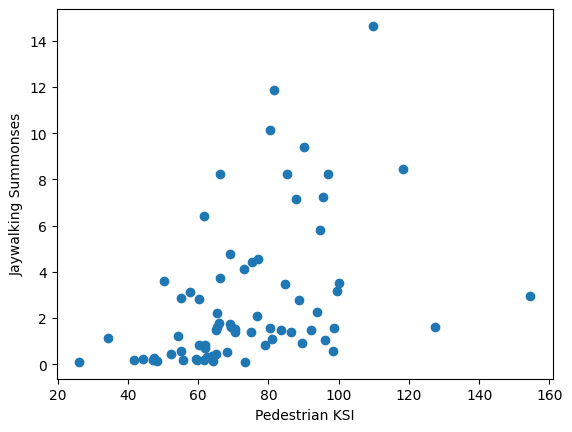

In [ ]:
# using dataset free of outliers

# scatter plot 

pedestrian_ksi_per10K = df_no_outliers['pedestrian_ksi_per10K']
total_jaywalking_summonses_per10K = df_no_outliers['total_jaywalking_summonses_per10K']

# add axis labels
plt.xlabel('Pedestrian KSI')
plt.ylabel('Jaywalking Summonses')

plt.scatter(pedestrian_ksi_per10K, total_jaywalking_summonses_per10K)
plt.show()

In [ ]:
# calculate Pearson correlation
pearson_corr, pearson_pval = pearsonr(pedestrian_ksi_per10K, total_jaywalking_summonses_per10K)

# calculate Spearman correlation
spearman_corr, spearman_pval = spearmanr(pedestrian_ksi_per10K, total_jaywalking_summonses_per10K)

print(f'Pearson correlation: {pearson_corr} (p-value: {pearson_pval})')
print(f'Spearman correlation: {spearman_corr} (p-value: {spearman_pval})')

Pearson correlation: 0.425456922358298 (p-value: 0.00019482777755462256)
Spearman correlation: 0.5601324844041418 (p-value: 3.1198129085241916e-07)
